Эта версия сделана для работы с cross-lingual выходами BEM модели. Само соревнование было полностью сделано на _v1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy import stats
from tqdm.auto import tqdm

In [2]:
pred_dev_filename = 'data/BEM-WiC-preds/XLM-R_05_unbal_large_best/preds_dev.en-en.data'
pred_test_filename = 'data/BEM-WiC-preds/crosslingual/last_range/preds_test.en-ar.data'
#pred_test_filename = 'data/BEM-WiC-preds/XLM-R_05_unbal_large_best/preds_test.zh-zh.data'
# pred_test_filename = 'data/BEM-WiC-preds/MCL_WiC_dev_ru_ru.txt'
#'data/bem/trial_predictions.txt'

In [3]:
def construct_preds(pred_filename):
    with open(pred_filename) as f:
        return json.load(f)

In [4]:
data_dev_files = 'data/MCL-WiC/dev/multilingual/dev.en-en'
#data_test_files = 'data/MCL-WiC/test/multilingual/test.zh-zh'
data_test_files = 'data/MCL-WiC/test/crosslingual/test.en-ar'

In [5]:
def construct_data_samples(data_files):
    with open(data_files + '.data') as f_data, open(data_files + '.gold') as f_labels:
        data_json = json.load(f_data)
        labels_json = json.load(f_labels)
    
    labels_dict = {sample['id']: sample for sample in labels_json}
    for sample in data_json:
        sample['tag'] = labels_dict[sample['id']]['tag']

    return data_json

In [6]:
def construct_test_data_samples(data_files):
    with open(data_files + '.data') as f_data:
        data_json = json.load(f_data)

    return data_json

In [7]:
def construct_samples(data_files, pred_filename, with_labels=True):
    preds = construct_preds(pred_filename)
    if with_labels:
        samples = construct_data_samples(data_files)
    else:
        samples = construct_test_data_samples(data_files)
    
    preds_dict = {pred['id']: pred for pred in preds}

    for sample in samples:
        pred = preds_dict[sample['id']]
        for key, value in pred.items():
            sample[key] = value
    
    return samples

In [8]:
dev_samples = construct_samples(data_dev_files, pred_dev_filename)
test_samples = construct_samples(data_test_files, pred_test_filename)

y_dev_true = [sample['tag'] == 'T' for sample in dev_samples]
y_test_true = [sample['tag'] == 'T' for sample in test_samples]

In [9]:
dev_samples[0]

{'id': 'dev.en-en.0',
 'lemma': 'superior',
 'pos': 'NOUN',
 'sentence1': 'No clause in a contract shall be interpreted as evading the responsibility of superiors under international law.',
 'sentence2': 'While fully aware that bishops and major superiors of religious institutes do not act as representatives or delegates of the Roman Pontiff, the Committee notes that subordinates in Catholic religious orders are bound by obedience to the Pope, in accordance with Canons 331 and 590 of the Code of canon Law.',
 'start1': '78',
 'end1': '87',
 'start2': '41',
 'end2': '50',
 'tag': 'F',
 'pred_label1': 'superior%1:18:01::',
 'probs1': {'superior%1:18:01::': 830.0606079101562,
  'superior%1:18:02::': 828.1439819335938,
  'superior%1:18:03::': 827.3997802734375,
  'superior%1:17:00::': 823.5405883789062,
  'superior%1:15:00::': 823.0596313476562,
  'superior%1:10:00::': 824.5357666015625},
 'context_output1': [-1.0631177425384521,
  -0.7975084781646729,
  -0.044733643531799316,
  -0.0866610

In [10]:
test_samples[0]

{'id': 'test.en-ar.0',
 'lemma': 'gently',
 'pos': 'ADV',
 'sentence1': "Unfortunately, that pressure seemed to have had some effect, and the Islamic Republic of Iran had been treated more gently in the 2008 Chairman's working paper.",
 'sentence2': 'وخلال هذا العقد، اتجهت الأسعار الحقيقية للسلع الأساسية نحو الارتفاع على نحو معتدل.',
 'ranges1': '116-122',
 'ranges2': '68-75',
 'tag': 'F',
 'context_output1': [-0.921518087387085,
  -0.7631620764732361,
  0.03808015212416649,
  -0.07943272590637207,
  0.2604595720767975,
  -0.822209358215332,
  0.40773695707321167,
  0.05239834263920784,
  0.30691763758659363,
  0.18075935542583466,
  0.11524072289466858,
  0.6806347370147705,
  -0.14351050555706024,
  -0.38906723260879517,
  0.18165600299835205,
  0.03593941777944565,
  -1.0448529720306396,
  0.05313087999820709,
  -0.06636346876621246,
  -0.5534689426422119,
  -0.21830004453659058,
  0.03300347924232483,
  0.18563324213027954,
  -0.33464640378952026,
  0.48269039392471313,
  0.3432481

In [11]:
from abc import ABC, abstractmethod

In [12]:
class AbsPredictor(ABC):
    @abstractmethod
    def predict(self, probs_1, probs_2):
        pass
    
    @abstractmethod
    def predict_proba(self, probs_1, probs_2):
        pass

In [13]:
class SimpleMatchPredictor(AbsPredictor):
    def predict(self, probs_1, probs_2):
        def get_biggest(d):
            return list(sorted(d.items(), key=lambda item: item[1], reverse=True))[0][0]

        return get_biggest(probs_1) == get_biggest(probs_2)
    
    def predict_proba(self, probs_1, probs_2):
        return None

In [14]:
class ConfidentPredictor(AbsPredictor):
    def __init__(self, threshold):
        self.threshold = threshold
        self.simple_predictor = SimpleMatchPredictor()
    
    def predict(self, probs_1, probs_2):
        is_conf_1 = max(probs_1.values()) >= self.threshold
        is_conf_2 = max(probs_2.values()) >= self.threshold
        conf_sum = sum([is_conf_1, is_conf_2])
        
        if conf_sum == 1:
            return False
    
        return self.simple_predictor.predict(probs_1, probs_2)
    
    def predict_proba(self, probs_1, probs_2):
        return None

In [15]:
class CorrPredictor(AbsPredictor):
    def __init__(self, threshold, stats_corr='pears'):
        assert stats_corr in ['pears', 'spearm']
        
        self.threshold = threshold
        self.stats_corr = stats_corr
    
    def predict_proba(self, probs_1, probs_2):
        if len(probs_1) < 2:
            return True
        
        lst_probs_1, lst_probs_2 = [], []
        for key in probs_1:
            lst_probs_1.append(probs_1[key])
            lst_probs_2.append(probs_2[key])
            
        if self.stats_corr == 'pears':
            corr, _ = stats.pearsonr(lst_probs_1, lst_probs_2)
        elif self.stats_corr == 'spearm':
            corr, _ = stats.spearmanr(lst_probs_1, lst_probs_2)
            
        return corr
    
    def predict(self, probs_1, probs_2):
        return self.predict_proba(probs_1, probs_2) >= self.threshold

In [16]:
class DiffPredictor(AbsPredictor):
    def __init__(self, threshold, normalize=True):
        self.threshold = threshold
        self.normalize = normalize
        
    def predict_proba(self, probs_1, probs_2):
        diff_sum = 0
        
        for key in probs_1:
            diff_sum += abs(probs_1[key] - probs_2[key])
        
        if self.normalize:
            diff_sum /= len(probs_1)
            
        return diff_sum
    
    def predict(self, probs_1, probs_2):
        return self.predict_proba(probs_1, probs_2) < self.threshold

In [17]:
class DivergencePredictor(AbsPredictor):
    def __init__(self, threshold, normalize=True, divergence='Kullback–Leibler'):
        assert divergence in ['Kullback–Leibler', 'Jensen–Shannon']
        
        self.threshold = threshold
        self.normalize = normalize
        self.divergence = divergence
        
    @staticmethod
    def _kullback_leibler(probs_1, probs_2):
        return sum(probs_1 * np.log(probs_1 / probs_2))
        
    def predict_proba(self, probs_1, probs_2):
        if len(probs_1) < 2:
            return True
        
        lst_probs_1, lst_probs_2 = [], []
        for key in probs_1:
            lst_probs_1.append(probs_1[key])
            lst_probs_2.append(probs_2[key])
            
        lst_probs_1 = np.array(lst_probs_1, dtype=np.float128)
        lst_probs_2 = np.array(lst_probs_2, dtype=np.float128)
            
        lst_probs_1 = np.exp(lst_probs_1) / sum(np.exp(lst_probs_1))
        lst_probs_2 = np.exp(lst_probs_2) / sum(np.exp(lst_probs_2))
        
        if self.divergence == 'Kullback–Leibler':
            diver = self._kullback_leibler(lst_probs_1, lst_probs_2)
        elif self.divergence == 'Jensen–Shannon':
            m = (lst_probs_1 + lst_probs_2) / 2
            diver = (self._kullback_leibler(lst_probs_1, m)
                   + self._kullback_leibler(lst_probs_2, m)) / 2
        
        if self.normalize:
            diver /= len(probs_1)
        
        return diver
    
    def predict(self, probs_1, probs_2):
        return self.predict_proba(probs_1, probs_2) < self.threshold

In [18]:
class ProbsDotPredictor(AbsPredictor):
    def __init__(self, threshold):
        self.threshold = threshold
        
    def predict_proba(self, probs_1, probs_2):
        lst_probs_1, lst_probs_2 = [], []
        for key in probs_1:
            lst_probs_1.append(probs_1[key])
            lst_probs_2.append(probs_2[key])
            
        lst_probs_1 = np.array(lst_probs_1, dtype=np.float128)
        lst_probs_2 = np.array(lst_probs_2, dtype=np.float128)
            
        lst_probs_1 = np.exp(lst_probs_1) / sum(np.exp(lst_probs_1))
        lst_probs_2 = np.exp(lst_probs_2) / sum(np.exp(lst_probs_2))
        
        return sum(lst_probs_1 * lst_probs_2)
    
    def predict(self, probs_1, probs_2):
        return self.predict_proba(probs_1, probs_2) > self.threshold

In [19]:
class VectorsDotPredictor(AbsPredictor):
    def __init__(self, threshold, normalize=True, norm_ord=2):
        self.threshold = threshold
        self.normalize = normalize
        self.norm_ord = norm_ord
    
    def predict(self, out_vector_1, out_vector_2):
        return self.predict_proba(out_vector_1, out_vector_2) > self.threshold
    
    def predict_proba(self, out_vector_1, out_vector_2):
        out_vector_1 = np.array(out_vector_1)
        out_vector_2 = np.array(out_vector_2)
        
        if self.normalize:
            out_vector_1 /= np.linalg.norm(out_vector_1, ord=self.norm_ord)
            out_vector_2 /= np.linalg.norm(out_vector_2, ord=self.norm_ord)
            
        return sum(out_vector_1 * out_vector_2)

In [20]:
class VectorsDistPredictor(AbsPredictor):
    def __init__(self, threshold, normalize=True, norm_ord=2):
        self.threshold = threshold
        self.normalize = normalize
        self.norm_ord = norm_ord
    
    def predict(self, out_vector_1, out_vector_2):
        return self.predict_proba(out_vector_1, out_vector_2) < self.threshold
    
    def predict_proba(self, out_vector_1, out_vector_2):
        out_vector_1 = np.array(out_vector_1)
        out_vector_2 = np.array(out_vector_2)
        
        if self.normalize:
            out_vector_1 /= np.linalg.norm(out_vector_1, ord=self.norm_ord)
            out_vector_2 /= np.linalg.norm(out_vector_2, ord=self.norm_ord)
        
        return np.linalg.norm(out_vector_1 - out_vector_2, ord=self.norm_ord)

In [21]:
def get_predictions(predictor, samples):
    return [predictor.predict(sample['probs1'], sample['probs2']) for sample in samples]

In [22]:
from sklearn.metrics import accuracy_score

Simple matching

In [23]:
y_dev_pred = get_predictions(SimpleMatchPredictor(), dev_samples)

accuracy_score(y_dev_true, y_dev_pred)

0.815

In [24]:
#y_test_pred = get_predictions(SimpleMatchPredictor(), test_samples)

#accuracy_score(y_test_true, y_test_pred)

Matching with thresholds

In [25]:
def plot_thresholds(predictor_class, samples, y_true, thresholds, **args):
    scores = []

    for threshold in tqdm(thresholds):
        y_pred = get_predictions(predictor_class(threshold=threshold, **args), samples)
        scores.append(accuracy_score(y_true, y_pred))

    plt.plot(thresholds, scores)
    
    args_str = str(args) if len(args) > 0 else ''
    plt.title(predictor_class.__name__ + ' ' + args_str)
    plt.xlabel('thresholds')
    plt.ylabel('accuracy')

    print('Best score:', max(scores), 'at threshold:', thresholds[np.argmax(scores)])

In [24]:
plot_thresholds(ProbsDotPredictor, dev_samples, y_dev_true, np.linspace(0, 1, 100))
#plot_thresholds(ProbsDotPredictor, test_samples, y_test_true, np.linspace(0, 1, 100))

plt.legend(['dev', 'test']);

  0%|          | 0/100 [00:00<?, ?it/s]

KeyError: 'probs1'

In [27]:
accuracy_score(y_test_true, get_predictions(
    ProbsDotPredictor(threshold=0.26262626262626265),
    test_samples))

0.754

Best score: 0.811 at threshold: 0.026755852842809364
Best score: 0.863 at threshold: 0.023411371237458192


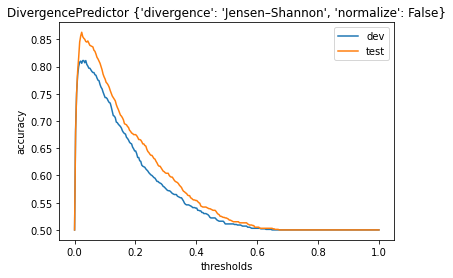

In [28]:
plot_thresholds(DivergencePredictor, dev_samples, y_dev_true, 
                np.linspace(0, 1, 300), divergence='Jensen–Shannon', normalize=False)
plot_thresholds(DivergencePredictor, test_samples, y_test_true, 
                np.linspace(0, 1, 300), divergence='Jensen–Shannon', normalize=False)

plt.legend(['dev', 'test']);

In [26]:
accuracy_score(y_test_true, get_predictions(
    DivergencePredictor(threshold=0.026755852842809364, divergence='Jensen–Shannon', normalize=False),
    test_samples))

KeyError: 'probs1'

# Context outputs

In [26]:
def get_predictions(predictor, samples):
    return [predictor.predict(sample['context_output1'], sample['context_output2']) for sample in samples]

  0%|          | 0/100 [00:00<?, ?it/s]

Best score: 0.869 at threshold: 0.9434343434343434


  0%|          | 0/100 [00:00<?, ?it/s]

Best score: 0.825 at threshold: 0.9232323232323232


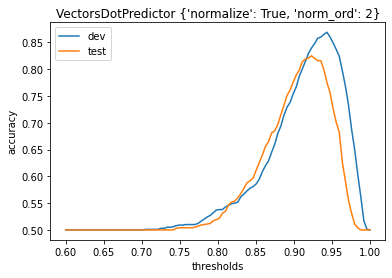

In [26]:
plot_thresholds(VectorsDotPredictor, dev_samples, y_dev_true, 
                np.linspace(0.6, 1, 100), normalize=True, norm_ord=2)
plot_thresholds(VectorsDotPredictor, test_samples, y_test_true, 
                np.linspace(0.6, 1, 100), normalize=True, norm_ord=2)

plt.legend(['dev', 'test']);

In [28]:
accuracy_score(y_test_true, get_predictions(
    VectorsDotPredictor(threshold=0.9191919191919191, normalize=True, norm_ord=2),
    test_samples))

0.857

  0%|          | 0/100 [00:00<?, ?it/s]

Best score: 0.867 at threshold: 0.33333333333333337


  0%|          | 0/100 [00:00<?, ?it/s]

Best score: 0.853 at threshold: 0.37373737373737376


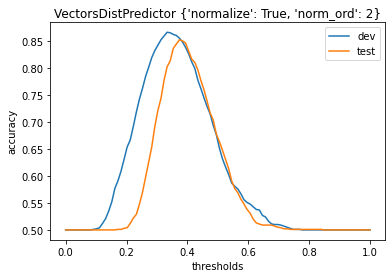

In [27]:
plot_thresholds(VectorsDistPredictor, dev_samples, y_dev_true, 
                np.linspace(0, 1, 100), normalize=True, norm_ord=2)
plot_thresholds(VectorsDistPredictor, test_samples, y_test_true, 
                np.linspace(0, 1, 100), normalize=True, norm_ord=2)

plt.legend(['dev', 'test']);

In [29]:
accuracy_score(y_test_true, get_predictions(
    VectorsDistPredictor(threshold=0.33333333333333337, normalize=True, norm_ord=2),
    test_samples))

0.803

  0%|          | 0/100 [00:00<?, ?it/s]

Best score: 0.886 at threshold: 0.6464646464646465


  0%|          | 0/100 [00:00<?, ?it/s]

Best score: 0.853 at threshold: 0.797979797979798


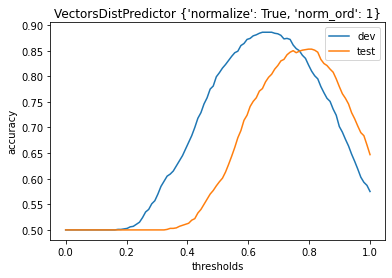

In [27]:
plot_thresholds(VectorsDistPredictor, dev_samples, y_dev_true, 
                np.linspace(0, 1, 100), normalize=True, norm_ord=1)
plot_thresholds(VectorsDistPredictor, test_samples, y_test_true, 
                np.linspace(0, 1, 100), normalize=True, norm_ord=1)

plt.legend(['dev', 'test']);
plt.savefig('data/image.pdf', bbox_inches='tight')

In [31]:
accuracy_score(y_test_true, get_predictions(
    VectorsDistPredictor(threshold=0.787878787878788, normalize=True, norm_ord=1),
    test_samples))

0.892

In [129]:
# 0.6464646464646465, Dev en threshold
# 0.7171717171717172, SemCor threshold
# 32,781 WiC samples transformed from SemCor data

accuracy_score(y_dev_true, get_predictions(
    VectorsDistPredictor(threshold=88.8888888888889, normalize=False, norm_ord=1),
    dev_samples))

Creating log-reg with params

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import inspect

In [21]:
def get_probs(predictor, samples):
    return [predictor.predict_proba(sample['probs1'], sample['probs2']) for sample in samples]

In [22]:
def construct_X_lr(base_predictors, samples):
    predictors_train_probs = [get_probs(predictor, samples) for predictor in base_predictors]
    return np.vstack(predictors_train_probs).T

In [23]:
lr_base_predictors = [
    CorrPredictor(threshold=None, stats_corr='pears'),
    CorrPredictor(threshold=None, stats_corr='spearm'),
    DiffPredictor(threshold=None, normalize=True),
    #DiffPredictor(threshold=None, normalize=False),
    #DivergencePredictor(threshold=None, divergence='Kullback–Leibler', normalize=True),
    DivergencePredictor(threshold=None, divergence='Kullback–Leibler', normalize=False),
    #DivergencePredictor(threshold=None, divergence='Jensen–Shannon', normalize=True),
    DivergencePredictor(threshold=None, divergence='Jensen–Shannon', normalize=False)
]

X_train = construct_X_lr(lr_base_predictors, train_samples)
X_dev = construct_X_lr(lr_base_predictors, dev_samples)

In [24]:
grid_params = {
    'C': np.linspace(0, 1, 20),
    'penalty': ['l1', 'l2']
}

lr = LogisticRegression(max_iter=300)
clf = GridSearchCV(lr, param_grid=grid_params, cv=5, n_jobs=-1)

clf.fit(X_train, y_train_true)
print('Best model params:', clf.best_params_)
best_clf = clf.best_estimator_
print('Train accuracy:', accuracy_score(y_train_true, best_clf.predict(X_train)))
print('Dev accuracy:', accuracy_score(y_dev_true, best_clf.predict(X_dev)))

Best model params: {'C': 0.7368421052631579, 'penalty': 'l2'}
Train accuracy: 0.7981226533166458
Dev accuracy: 0.841


/Users/maxim_rachinskiy/Develop/Education/Coursework_2020-2021/MCL_WiC/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.79536921        nan 0.79612015
        nan 0.79586984        nan 0.79574468        nan 0.79586984
        nan 0.79624531        nan 0.79599499        nan 0.79624531
        nan 0.79662078        nan 0.79674593        nan 0.79662078
        nan 0.7971214         nan 0.79737171        nan 0.79749687
        nan 0.79749687        nan 0.79737171        nan 0.79737171
        nan 0.79724656        nan 0.79724656]
  category=UserWarning


In [236]:
def get_obj_info(obj):
    return obj.__class__.__name__ + ": " + str(obj.__dict__)

In [237]:
importance_df = pd.DataFrame({
    'coef': best_clf.coef_[0],
    'base_model': [get_obj_info(pred) for pred in lr_base_predictors]
})

pd.set_option('max_colwidth', None)
importance_df.sort_values(by='coef', ascending=False)

,coef,base_model
0,0.461818,"CorrPredictor: {'threshold': None, 'stats_corr': 'pears'}"
1,0.358924,"CorrPredictor: {'threshold': None, 'stats_corr': 'spearm'}"
2,-0.420496,"DiffPredictor: {'threshold': None, 'normalize': True}"
3,-0.727151,"DivergencePredictor: {'threshold': None, 'normalize': False, 'divergence': 'Kullback–Leibler'}"
4,-4.458015,"DivergencePredictor: {'threshold': None, 'normalize': False, 'divergence': 'Jensen–Shannon'}"


Analysis of train and dev dataset

In [20]:
from sklearn.model_selection import KFold

In [21]:
def test_folds(predictor, samples, y_true, n_splits=8, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    samples_np = np.array(samples)
    y_true_np = np.array(y_true)

    for i, (_, test_index) in enumerate(kf.split(samples_np)):
        y_train_pred = get_predictions(predictor, samples_np[test_index])
        print(f'Fold #{i}', accuracy_score(y_true_np[test_index], y_train_pred))

In [22]:
div_predictor = DivergencePredictor(threshold=0.07357859531772575, divergence='Jensen–Shannon', normalize=False)

In [23]:
print('Train results:')
test_folds(div_predictor, train_samples, y_train_true, n_splits=8, random_state=42)

Train results:
Fold #0 0.8048048048048048
Fold #1 0.7827827827827828
Fold #2 0.8158158158158159
Fold #3 0.7907907907907908
Fold #4 0.7777777777777778
Fold #5 0.7837837837837838
Fold #6 0.7775551102204409
Fold #7 0.7955911823647295


In [24]:
print('Dev results:')
test_folds(div_predictor, dev_samples, y_dev_true, n_splits=8, random_state=42)

Dev results:
Fold #0 0.848
Fold #1 0.848
Fold #2 0.832
Fold #3 0.864
Fold #4 0.792
Fold #5 0.832
Fold #6 0.888
Fold #7 0.816


Analysis of frequencies of words in train and dev

In [61]:
from wordfreq import word_frequency

In [72]:
def calculate_frequencies(samples):
    return [word_frequency(sample['lemma'], 'en') for sample in samples]

In [257]:
dev_freqs = calculate_frequencies(dev_samples)
train_freqs = calculate_frequencies(train_samples)

print('Aver frequency for dev:', np.quantile(dev_freqs, q=0.5))
print('Aver frequency for train:', np.quantile(train_freqs, q=0.5))

Aver frequency for dev: 7.850000000000001e-06
Aver frequency for train: 9.55e-06


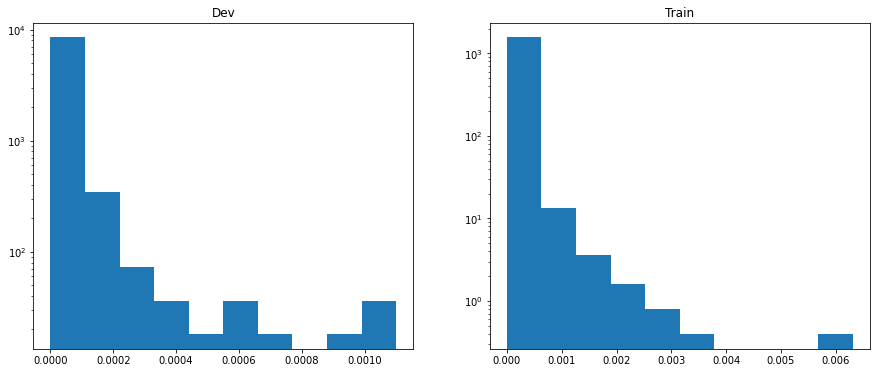

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(dev_freqs, log=True, density=True)
axes[0].set_title('Dev')
axes[1].hist(train_freqs, log=True, density=True)
axes[1].set_title('Train');

Analysis of senses number in train and dev

In [87]:
def calculate_senses_numbers(samples):
    return [len(sample['probs1']) for sample in samples]

In [88]:
dev_senses_numbers = calculate_senses_numbers(dev_samples)
train_senses_numbers = calculate_senses_numbers(train_samples)

print('Aver frequency for dev:', np.mean(dev_senses_numbers))
print('Aver frequency for train:', np.mean(train_senses_numbers))

Aver frequency for dev: 4.736
Aver frequency for train: 4.899123904881101


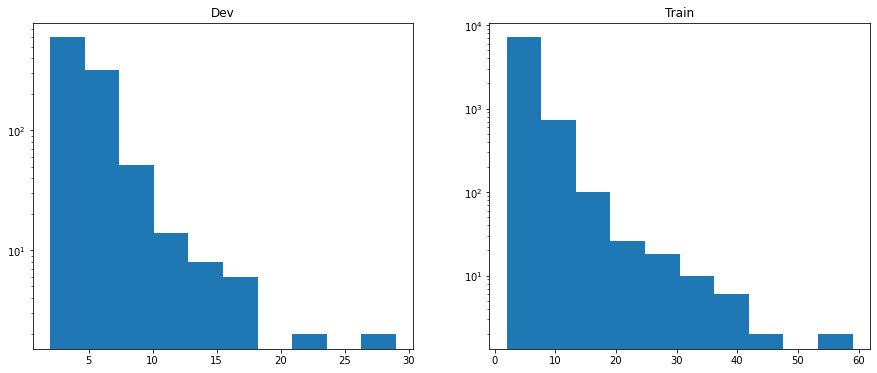

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(dev_senses_numbers, log=True)
axes[0].set_title('Dev')
axes[1].hist(train_senses_numbers, log=True)
axes[1].set_title('Train');

Submission

In [89]:
def create_submission(samples, preds):
    labels = ['T' if pred else 'F' for pred in preds]
    submission = []
    
    for i in range(len(samples)):
        current_pred = {
            'id': samples[i]['id'],
            'tag': labels[i]
        }
        submission.append(current_pred)
        
    return submission

In [27]:
div_predictor = DivergencePredictor(threshold=0.07357859531772575, divergence='Jensen–Shannon', normalize=False)

test_preds = get_predictions(div_predictor, test_samples)
print(sum(test_preds) / len(test_preds))

0.556


In [35]:
submission = create_submission(test_samples, test_preds)

with open('data/preds/test.en-en', 'w') as f:
    json.dump(submission, f, indent=4)

print(submission[:10])

[{'id': 'test.en-en.0', 'tag': 'F'}, {'id': 'test.en-en.1', 'tag': 'F'}, {'id': 'test.en-en.2', 'tag': 'T'}, {'id': 'test.en-en.3', 'tag': 'T'}, {'id': 'test.en-en.4', 'tag': 'T'}, {'id': 'test.en-en.5', 'tag': 'T'}, {'id': 'test.en-en.6', 'tag': 'T'}, {'id': 'test.en-en.7', 'tag': 'T'}, {'id': 'test.en-en.8', 'tag': 'T'}, {'id': 'test.en-en.9', 'tag': 'T'}]


Experiments with translations

In [134]:
pred_dev_ru_filename = 'data/bem/dev_ar_ar_predictions.txt'
data_dev_ru_files = 'data/translations_data/trans_dev.ar-en'

pred_test_ru_filename = 'data/bem/test_ar_ar_predictions.txt'
data_test_ru_files = 'data/translations_data/trans_test.ar-en'

In [135]:
dev_ru_samples = construct_samples(data_dev_ru_files, pred_dev_ru_filename)
test_ru_samples = construct_samples(data_test_ru_files, pred_test_ru_filename, with_labels=False)

In [136]:
def get_translated_predictions(predictor, samples):
    preds = []
    
    for sample in samples:
        if sample['match_count'] == 2:
            if len(sample['probs1']) > 0:
                preds.append(predictor.predict(sample['probs1'], sample['probs2']))
            else:
                preds.append(sample['is_trans_equal'])
        elif sample['match_count'] == 1:
            preds.append(False)
        else:
            preds.append(True)
            
    return preds

In [137]:
y_dev_ru_true = [sample['tag'] == 'T' for sample in dev_ru_samples]
y_dev_ru_pred = get_translated_predictions(SimpleMatchPredictor(), dev_ru_samples)

accuracy_score(y_dev_ru_true, y_dev_ru_pred)

0.503

In [138]:
def plot_translated_thresholds(predictor_class, samples, y_true, thresholds, **args):
    scores = []

    for threshold in thresholds:
        y_pred = get_translated_predictions(predictor_class(threshold=threshold, **args), samples)
        scores.append(accuracy_score(y_true, y_pred))

    plt.plot(thresholds, scores)
    
    args_str = str(args) if len(args) > 0 else ''
    plt.title(predictor_class.__name__ + ' ' + args_str)
    plt.xlabel('thresholds')
    plt.ylabel('accuracy')

    print('Best score:', max(scores), 'at threshold:', thresholds[np.argmax(scores)])

Best score: 0.504 at threshold: 0.05351170568561873


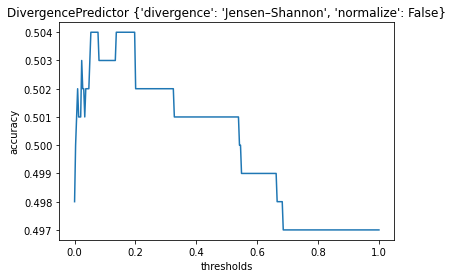

In [139]:
plot_translated_thresholds(DivergencePredictor, dev_ru_samples, y_dev_ru_true, 
                           np.linspace(0, 1, 300), divergence='Jensen–Shannon', normalize=False)

Best score: 0.725 at threshold: 0.18729096989966554


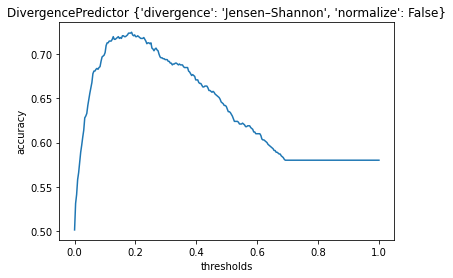

In [85]:
plot_translated_thresholds(DivergencePredictor, dev_ru_samples, y_dev_ru_true, 
                           np.linspace(0, 1, 300), divergence='Jensen–Shannon', normalize=False)

Submission

In [140]:
div_predictor = DivergencePredictor(threshold=0.05351170568561873, divergence='Jensen–Shannon', normalize=False)

In [141]:
test_preds = get_translated_predictions(div_predictor, test_ru_samples)
print(sum(test_preds) / len(test_preds))

0.983


In [142]:
test_ru_samples[:5]

[{'id': 'test.ar-ar.0',
  'lemma': 'خَدَمَ',
  'pos': 'VERB',
  'sentence1': 'وكان ستون من مراقبي الشرطة هؤﻻء قد خدموا في اﻷمم المتحدة من قبل.',
  'sentence2': 'وآخر فئة من الموظفين ينظر في أمر انهاء خدماتهم بشكل غير طوعي هم الخبراء والموظفون اﻷكفاء الذين خدموا المنظمة لفترات طويلة وساهموا في نجاح المنظمة.',
  'start1': '35',
  'end1': '40',
  'start2': '95',
  'end2': '100',
  'trans_sentence1': 'Sixty of those police monitors had previously served in the United Nations.',
  'trans_sentence2': 'The last category of staff considered for involuntary termination were experts and competent staff who had served the Organization for long periods and had contributed to the success of the Organization.',
  'lemma_trans': [],
  'match_count': 0,
  'is_trans_equal': None,
  'trans_start1': None,
  'trans_end1': None,
  'trans_start2': None,
  'trans_end2': None,
  'probs1': None,
  'probs2': None},
 {'id': 'test.ar-ar.1',
  'lemma': 'خَدَمَ',
  'pos': 'VERB',
  'sentence1': 'وكان ستون من مراقبي

In [143]:
submission = create_submission(test_ru_samples, test_preds)

with open('data/preds/test.ar-ar', 'w') as f:
    json.dump(submission, f, indent=4)

print(submission[:10])

[{'id': 'test.ar-ar.0', 'tag': 'T'}, {'id': 'test.ar-ar.1', 'tag': 'T'}, {'id': 'test.ar-ar.2', 'tag': 'T'}, {'id': 'test.ar-ar.3', 'tag': 'T'}, {'id': 'test.ar-ar.4', 'tag': 'T'}, {'id': 'test.ar-ar.5', 'tag': 'T'}, {'id': 'test.ar-ar.6', 'tag': 'T'}, {'id': 'test.ar-ar.7', 'tag': 'T'}, {'id': 'test.ar-ar.8', 'tag': 'T'}, {'id': 'test.ar-ar.9', 'tag': 'T'}]
